In [ ]:
!pip install -q split-folders
import splitfolders
import matplotlib.pyplot as plt
import os
import glob
import cv2
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import Model
from keras.models import load_model
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Input, Activation, BatchNormalization
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Functions**

In [ ]:
# Define the threshold below which the pixels will be converted to black
threshold = 128

# Define the path to the directory containing the images
img_dir = '/content/drive/MyDrive/Multiclass/data_threshold'

# Walk through the directory and convert each image
for root, dirs, files in os.walk(img_dir):
    for file in files:
        if file.endswith('.jpg'):
            # Load the image
            img = cv2.imread(os.path.join(root, file), cv2.IMREAD_GRAYSCALE)
            
            # Convert the pixels below the threshold to black
            img[img < threshold] = 0
            
            # Save the converted image
            cv2.imwrite(os.path.join(root, file), img)

In [ ]:
# Set the path to the main folder and the destination folder
destination_folder = '/content/drive/MyDrive/Multiclass'

# Split the main folder into train and validation sets in a ratio
def split():  
    splitfolders.ratio('/content/drive/MyDrive/Multiclass/data_threshold', output = destination_folder,
                       seed = 22, ratio = (0.7, 0.15, 0.15), group_prefix = None, move = False)

if os.path.exists('/content/drive/MyDrive/Multiclass/train'):
    print("Files already present in splitted ratio 0.7, 0.15 and 0.15")
else:
    split()
    print("Files are splitted in the ratio 0.7, 0.15 and 0.15")

Copying files: 1884 files [00:32, 58.13 files/s]

Files are splitted in the ratio 0.7, 0.15 and 0.15


# **Data Visualisation**

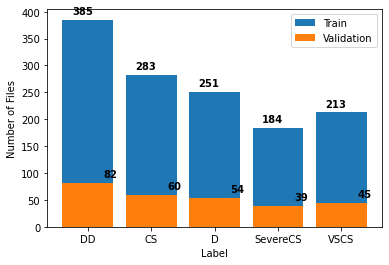

In [ ]:
train_dir = '/content/drive/MyDrive/Multiclass/train'
val_dir = '/content/drive/MyDrive/Multiclass/val'
test_dir = '/content/drive/MyDrive/Multiclass/test'

train_labels = []
train_counts = []
val_labels = []
val_counts = []
test_labels = []
test_counts = []

for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)
    if os.path.isdir(label_dir):
        train_labels.append(label)
        train_counts.append(len(os.listdir(label_dir)))

for label in os.listdir(val_dir):
    label_dir = os.path.join(val_dir, label)
    if os.path.isdir(label_dir):
        val_labels.append(label)
        val_counts.append(len(os.listdir(label_dir)))

fig, ax = plt.subplots()
ax.bar(train_labels, train_counts, label = 'Train')
ax.bar(val_labels, val_counts, label = 'Validation')
ax.set_xlabel('Label')
ax.set_ylabel('Number of Files')

for i, v in enumerate(train_counts):
    ax.text(i - 0.25, v + 10, str(v), fontweight = 'bold')
for i, v in enumerate(val_counts):
    ax.text(i + 0.25, v + 10, str(v), fontweight = 'bold') 
    
    
ax.legend()
plt.show()

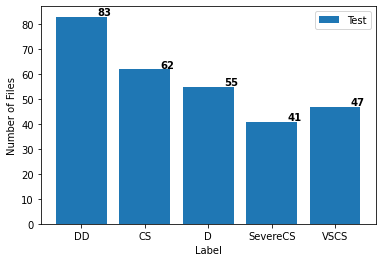

In [ ]:
for label in os.listdir(test_dir):
    label_dir = os.path.join(test_dir, label)
    if os.path.isdir(label_dir):
        test_labels.append(label)
        test_counts.append(len(os.listdir(label_dir)))
        
fig, ax = plt.subplots()
ax.bar(test_labels, test_counts, label = 'Test')
ax.set_xlabel('Label')
ax.set_ylabel('Number of Files')

for i, v in enumerate(test_counts):
    ax.text(i + 0.25, v + 0.5, str(v), fontweight = 'bold') 

ax.legend()
plt.show()

In [ ]:
train_images = glob.glob('/content/drive/MyDrive/Multiclass/train/*/*.jpg')
val_images = glob.glob('/content/drive/MyDrive/Multiclass/val/*/*.jpg')
test_images = glob.glob('/content/drive/MyDrive/Multiclass/test/*/*.jpg')

total_images = len(train_images) + len(val_images) + len(test_images)

print("Total number of images",total_images,"\n")

ratios = []

for i in range(len(train_counts)):
  ratio = (train_counts[i] / (train_counts[i] + val_counts[i])) * 100
  ratios.append(ratio)
print('Training : Validation')
for i in range(len(ratios)):
  print(f'{ratios[i]:.0f}:{100-ratios[i]:.0f}')

Total number of images 1884 

Training : Validation
82:18
83:17
82:18
83:17
83:17


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, fill_mode='constant', cval=0)
train_generator = train_datagen.flow_from_directory(train_dir, target_size = (310,310), batch_size = 2, class_mode='categorical', shuffle = True)

val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = val_datagen.flow_from_directory(val_dir, target_size = (310, 310), batch_size = 1, class_mode = 'categorical', shuffle = False)

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size = (310, 310), batch_size = 1, class_mode = 'categorical', shuffle = False)

# Get the class names from the generator
val_class_names = list(val_generator.class_indices.keys())
print("Validation dataset class names",val_class_names)

Found 1316 images belonging to 5 classes.
Found 280 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Validation dataset class names ['CS', 'D', 'DD', 'SevereCS', 'VSCS']


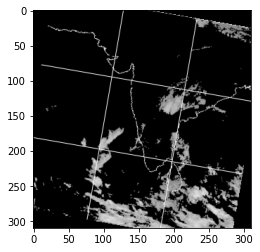

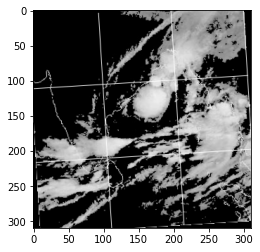

In [ ]:
# Get a batch of images from the train_generator
images, labels = next(train_generator)

# Plot the images
for i in range(len(images)):
    plt.figure()
    plt.imshow(images[i])

# Show the plot
plt.show()

In [ ]:
# Load the Proposed Model
proposed_model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(32, (3, 3), input_shape = (310, 310, 3), activation = 'relu'),
tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
tf.keras.layers.Dropout(0.4),

tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
tf.keras.layers.Dropout(0.4),

tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
tf.keras.layers.Dropout(0.4),

tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
tf.keras.layers.Dropout(0.4),

tf.keras.layers.Flatten(),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(units = 512, activation = 'relu'),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(5, activation = 'softmax', kernel_regularizer = regularizers.l2(0.01))
])

In [ ]:
total_count = sum(train_counts)
train_counts = np.array(train_counts)
alpha = (1 - train_counts / total_count)

from tensorflow import keras as K
# Define the Focal Loss function
def focal_loss(gamma=2., alpha=alpha):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -tf.math.reduce_mean(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1)) - tf.math.reduce_mean((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0))
    return focal_loss_fixed

proposed_model.compile(optimizer = Adam(learning_rate = 0.0001), loss = focal_loss(gamma=2., alpha = alpha), metrics = ['accuracy'])

In [ ]:
# Compile the model with a optimizer and loss function
proposed_model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

checkpoint = ModelCheckpoint('/content/drive/MyDrive/multiclass_proposed_best_weights.h5', monitor = 'val_accuracy', save_best_only = True, mode = 'max')

# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

# Create a ReduceLROnPlateau callback with a factor of 0.1
lr_scheduler = ReduceLROnPlateau(factor = 0.1, patience = 5)

# set the number os steps of each epoch
validation_steps = val_generator.samples//1
training_steps = train_generator.samples//2 

In [ ]:
history = proposed_model.fit(train_generator, steps_per_epoch=training_steps, epochs=50, validation_data=val_generator, validation_steps=validation_steps, verbose=1, callbacks=[checkpoint, lr_scheduler, early_stopping])

Epoch 1/50
658/658 [==============================] - 265s 385ms/step - loss: 1.6988 - accuracy: 0.2690 - val_loss: 1.6674 - val_accuracy: 0.2929 - lr: 1.0000e-04
Epoch 2/50
658/658 [==============================] - 40s 62ms/step - loss: 1.6205 - accuracy: 0.3169 - val_loss: 1.6487 - val_accuracy: 0.3036 - lr: 1.0000e-04
Epoch 3/50
658/658 [==============================] - 39s 59ms/step - loss: 1.5779 - accuracy: 0.3374 - val_loss: 1.6132 - val_accuracy: 0.2929 - lr: 1.0000e-04
Epoch 4/50
658/658 [==============================] - 40s 61ms/step - loss: 1.5338 - accuracy: 0.3457 - val_loss: 1.5641 - val_accuracy: 0.3393 - lr: 1.0000e-04
Epoch 5/50
658/658 [==============================] - 41s 62ms/step - loss: 1.5016 - accuracy: 0.3845 - val_loss: 1.5525 - val_accuracy: 0.3571 - lr: 1.0000e-04
Epoch 6/50
658/658 [==============================] - 39s 59ms/step - loss: 1.4470 - accuracy: 0.3997 - val_loss: 1.5423 - val_accuracy: 0.3571 - lr: 1.0000e-04
Epoch 7/50
658/658 [============

0.6035714149475098


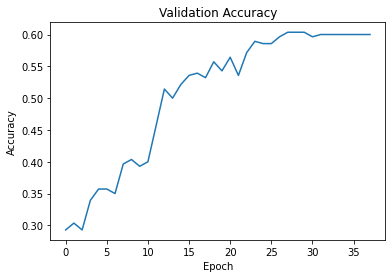

In [ ]:
# Extract the validation accuracy from the history object
val_acc = history.history['val_accuracy']
print(max(val_acc))

# Plot the validation accuracy over the course of training
plt.plot(val_acc)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Load the model from the file
model = load_model('/content/drive/MyDrive/multiclass_proposed_best_weights.h5')

val_generator.reset()
val_predictions = model.predict(val_generator)

label_map = dict((v, k) for k, v in val_generator.class_indices.items())
print(label_map)

actualLables_val = [label_map[k] for k in val_generator.classes]
print("Length of actual validation labels:", len(actualLables_val))

# Generate predictions for the validation data
val_predictions = model.predict(val_generator, verbose = 1)

# Convert the predictions to a one-hot encoded format
val_predictions = np.argmax(val_predictions, axis=1)
predictedLables_val = [label_map[k] for k in val_predictions]

val_loss, val_accuracy = model.evaluate(val_generator, batch_size=1)
print(f"Validation Loss:    {val_loss}")
print(f"Validation Accuracy:{val_accuracy}")

# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(actualLables_val, predictedLables_val)

print(confusion_matrix)

280/280 [==============================] - 2s 7ms/step
{0: 'CS', 1: 'D', 2: 'DD', 3: 'SevereCS', 4: 'VSCS'}
Length of actual validation labels: 280
280/280 [==============================] - 2s 6ms/step - loss: 1.3290 - accuracy: 0.6036
Validation Loss:    1.3290067911148071
Validation Accuracy:0.6035714149475098
[[27  5 23  5  0]
 [ 4 36 13  1  0]
 [18 13 50  1  0]
 [ 4  1  4 23  7]
 [ 3  0  5  4 33]]


In [ ]:
test_generator.reset()
test_predictions = model.predict(test_generator)

label_map = dict((v, k) for k, v in test_generator.class_indices.items())
print(label_map)

actualLables_test = [label_map[k] for k in test_generator.classes]
print("Length of actual validation labels:", len(actualLables_test))

# Convert the predictions to a one-hot encoded format
test_predictions = np.argmax(test_predictions, axis = 1)
predictedLables_test = [label_map[k] for k in test_predictions]

# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
confusion_matrix = sk_confusion_matrix(actualLables_test, predictedLables_test)

print(confusion_matrix)

test_loss, test_accuracy=model.evaluate(test_generator, batch_size=1)
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

288/288 [==============================] - 2s 6ms/step
{0: 'CS', 1: 'D', 2: 'DD', 3: 'SevereCS', 4: 'VSCS'}
Length of actual validation labels: 288
[[33  5 14  8  2]
 [ 4 37 13  0  1]
 [10 10 58  3  2]
 [ 9  2  4 24  2]
 [ 3  3  6  6 29]]
288/288 [==============================] - 3s 9ms/step - loss: 1.2727 - accuracy: 0.6285
Test Loss:     1.2727081775665283
Test Accuracy: 0.6284722089767456


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
print(classification_report(actualLables_test, predictedLables_test))

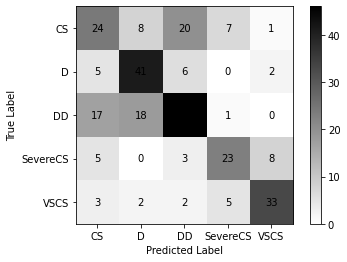

In [ ]:
plt.imshow(confusion_matrix, cmap='binary')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(np.unique(actualLables_val))), np.unique(actualLables_val))
plt.yticks(np.arange(len(np.unique(actualLables_val))), np.unique(actualLables_val))
plt.colorbar()

for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='black')

plt.show()

In [ ]:
print("Actual \t Predicted")
for i in range(len(actualLables_val)):
    print(actualLables_val[i] + '\t ' + predictedLables_val[i])

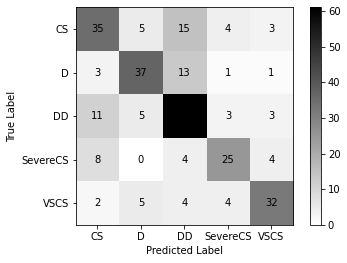

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(actualLables_test, predictedLables_test)

plt.imshow(conf_mat, cmap='binary')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(np.unique(actualLables_test))), np.unique(actualLables_test))
plt.yticks(np.arange(len(np.unique(actualLables_test))), np.unique(actualLables_test))
plt.colorbar()

for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        plt.text(j, i, conf_mat[i, j], ha='center', va='center', color='black')

plt.show()

In [ ]:
print("Actual \t Predicted")
for i in range(len(actualLables_test)):
    print(actualLables_test[i] + '\t ' + predictedLables_test[i])

In [ ]:
filenames = test_generator.filenames

filtered_filenames = []
filtered_actualLables_test = []
filtered_predictedLables_test = []

for filename in filenames:
    if '/2021' in filename and '.jpg' in filename:
        filtered_filenames.append(filename)
        index = filenames.index(filename)
        filtered_actualLables_test.append(actualLables_test[index])
        filtered_predictedLables_test.append(predictedLables_test[index])

data = {'Filename': filtered_filenames, 'Actual': filtered_actualLables_test, 'Predicted': filtered_predictedLables_test}
df = pd.DataFrame(data)
df.to_csv('results2021.csv', index=False)

# **Regression**

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from keras.optimizers import Adam
import os.path
import os
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tensorflow.keras.layers import Conv2D, Dropout, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras import regularizers

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define the threshold below which the pixels will be converted to black
threshold = 128

# Define the path to the directory containing the images
img_dir = '/content/drive/MyDrive/Regression/data_threshold'

# Walk through the directory and convert each image
for root, dirs, files in os.walk(img_dir):
    for file in files:
        if file.endswith('.jpg'):
            # Load the image
            img = cv2.imread(os.path.join(root, file), cv2.IMREAD_GRAYSCALE)
            
            # Convert the pixels below the threshold to black
            img[img < threshold] = 0
            
            # Save the converted image
            cv2.imwrite(os.path.join(root, file), img)

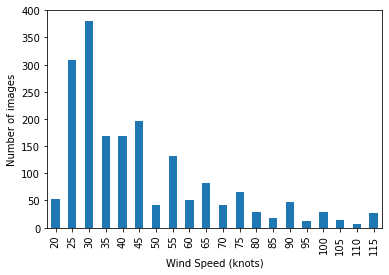

In [ ]:
image_dir = Path('/content/drive/MyDrive/Regression/data_threshold')

filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
intensity = pd.Series(filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name = 'Intensity').astype(np.int32)

images = pd.concat([filepaths, intensity], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)

image_df = images.sample(len(images), random_state=1).reset_index(drop=True)

train_df, val_df = train_test_split(image_df, test_size=0.3, shuffle=True, random_state=1)
val_df, test_df = train_test_split(val_df, test_size=0.5, shuffle=True, random_state=1)

train_labels = train_df.iloc[:, -1].values
val_labels = val_df.iloc[:, -1].values

images.Intensity.value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Wind Speed (knots)')
plt.ylabel('Number of images')
plt.show()

In [ ]:
train_generator = ImageDataGenerator(rescale = 1./255, rotation_range=10, fill_mode='constant', cval=0)
train_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='Filepath', y_col='Intensity', target_size=(310, 310), 
                                                   class_mode='raw', batch_size=2, shuffle=True)

val_generator = ImageDataGenerator(rescale = 1./255)
val_images = val_generator.flow_from_dataframe(dataframe=val_df, x_col='Filepath', y_col='Intensity', target_size=(310, 310), class_mode='raw', 
                                               batch_size=1, shuffle=False)

test_generator = ImageDataGenerator(rescale = 1./255)
test_images = test_generator.flow_from_dataframe(dataframe=test_df, x_col='Filepath', y_col='Intensity', target_size=(310, 310), 
                                                 class_mode='raw', batch_size=1, shuffle=False)

Found 1308 validated image filenames.
Found 280 validated image filenames.
Found 281 validated image filenames.


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (310, 310, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear', kernel_regularizer=regularizers.l2(0.01)))

model.compile(optimizer='adam', loss='mean_squared_error')

# Create a checkpoint to save best weights
checkpoint = ModelCheckpoint('/content/drive/MyDrive/regression_proposed_best_weights.h5', monitor='val_loss', save_best_only=True, mode='min')

# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Create a ReduceLROnPlateau callback with a factor of 0.1
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=5)

In [ ]:
history = model.fit(train_images, validation_data = val_images, epochs = 40, callbacks = [checkpoint, early_stopping, lr_scheduler], verbose = 1)

Epoch 1/40
654/654 [==============================] - 49s 72ms/step - loss: 579.7142 - val_loss: 453.8869 - lr: 0.0010
Epoch 2/40
654/654 [==============================] - 41s 63ms/step - loss: 510.2636 - val_loss: 387.8402 - lr: 0.0010
Epoch 3/40
654/654 [==============================] - 43s 66ms/step - loss: 520.5903 - val_loss: 360.9226 - lr: 0.0010
Epoch 4/40
654/654 [==============================] - 41s 62ms/step - loss: 490.2356 - val_loss: 368.6065 - lr: 0.0010
Epoch 5/40
654/654 [==============================] - 42s 64ms/step - loss: 497.2052 - val_loss: 360.5726 - lr: 0.0010
Epoch 6/40
654/654 [==============================] - 45s 69ms/step - loss: 468.3151 - val_loss: 359.9156 - lr: 0.0010
Epoch 7/40
654/654 [==============================] - 43s 66ms/step - loss: 493.6418 - val_loss: 358.8112 - lr: 0.0010
Epoch 8/40
654/654 [==============================] - 41s 62ms/step - loss: 467.0493 - val_loss: 404.4328 - lr: 0.0010
Epoch 9/40
654/654 [============================

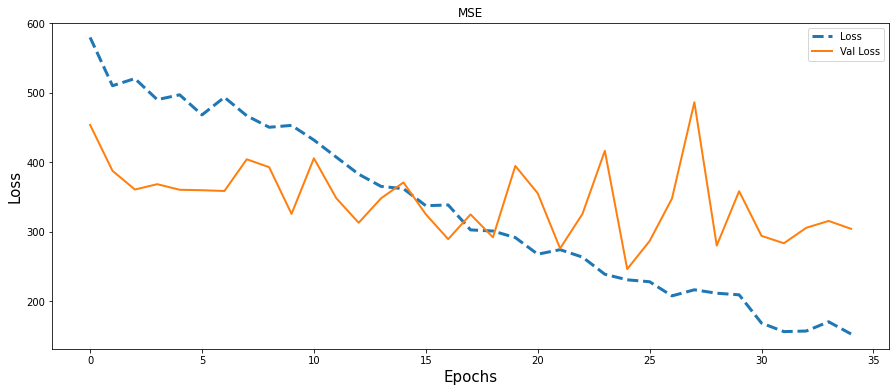

In [ ]:
model = load_model('/content/drive/MyDrive/regression_proposed_best_weights.h5')

plt.figure(figsize = (15, 6))
plt.plot(history.history['loss'], lw = 3, ls = '--', label = 'Loss')
plt.plot(history.history['val_loss'], lw =2, ls = '-', label = 'Val Loss')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.title('MSE')
plt.legend();

In [ ]:
val_images.reset()
predicted_intensity = np.squeeze(model.predict(val_images))
#predicted_intensity = np.round(predicted_intensity/5, 0)*5
true_intensity = val_images.labels

rmse = np.sqrt(model.evaluate(val_images, verbose = 0))
print("Validation RMSE: {:.5f}".format(rmse))

print('Standard deviation in predicted validation intensities:', np.std(predicted_intensity))
mse = mean_squared_error(true_intensity, predicted_intensity)
print('Validation MSE: {:.2f}'.format(mse))
mae = mean_absolute_error(true_intensity, predicted_intensity)
print('Validation MAE: {:.2f}'.format(mae))

280/280 [==============================] - 2s 5ms/step
Validation RMSE: 15.69815
Standard deviation in predicted validation intensities: 15.500178
Validation MSE: 246.41
Validation MAE: 11.30


In [ ]:
test_images.reset()
predicted_intensity = np.squeeze(model.predict(test_images))
#predicted_intensity = np.round(predicted_intensity/5, 0)*5
true_intensity = test_images.labels

rmse = np.sqrt(model.evaluate(test_images, verbose=0))
print("     Test RMSE: {:.5f}".format(rmse))

mae = mean_absolute_error(true_intensity, predicted_intensity)
print('Test MAE: {:.2f}'.format(mae))

mse = mean_squared_error(true_intensity, predicted_intensity)
print('Test MSE: {:.2f}'.format(mse))

281/281 [==============================] - 2s 6ms/step
     Test RMSE: 15.93533
Test MAE: 11.73
Test MSE: 253.91


In [ ]:
print("{0:5} {1:10} {2}".format("True", "Predicted", "Filenames"))
for i in range(len(predicted_intensity[:96])):
    print("{0:5} {1:10} {2}".format(true_intensity[i], int(predicted_intensity[i]), test_images.filenames[i]))